# Exploring Tradeoffs Between Growth and Death In Feast-and-Famine Environments

In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
import growth.viz 
import growth.model
import seaborn as sns

#Set a random seed 2039
rng = np.random.default_rng(seed=2039)
cor, pal = growth.viz.matplotlib_style()


In this notebook, I'll explore some basic, exploratory simulations of self-replicating 
microbes growing in a boom-and-bust environment. To do so, we will use the `growth`
Python module written for this project.

## Model
Let's briefly rehash the model. We will suppose that we have a semi-open ecosystem $E$ composed of $N_{s}$ self-replicating species. This ecosystem is semi-open, meaning that nutrients can flow in and out at a rate $\delta$, but species can only flow out at a rate $\delta$ or die at a rate $\gamma$. We will suppose that these species can eat either the nutrients, present in the environment at a concentration $c_{nut}$, or the necromass, present at a concentration $c_{necro}$, with maximum rates of $\lambda_{nut}$ and $\lambda_{necro}$, respectively. We will assume that each species $s \in N_{s}$ grows on nutrients and necromass with Monod functions of the form
$$
\begin{equation}
\lambda_{nut} = \lambda_{nut}^{(max)} \frac{c_{nut}}{c_{nut} + K_{M}^{(nut)}}\tag{1}
\end{equation}
$$
and 
$$
\begin{equation}
\lambda_{necro} = \lambda_{necro}^{(max)}\frac{c_{necro}}{c_{necro} + K_{M}^{(necro)}},
\tag{2}
\end{equation}
$$
respectively. Here, $K_M$ corresponds to the Monod constant and $\lambda^{(max)}$ denotes the maximum possible growth rate on each component. 

With this in hand, we can write out the dynamics for each species in the ecosystem. The total biomass $M$ of a species $s$ is dependent on the growth rates $\lambda_{nut}$ and $\lambda_{necro}$, the death rate $\gamma_s$, and the outflow rate $\delta$. Mathematically, this translates to 

$$
\begin{equation}
\frac{dM_s}{dt} = \lambda_{nut, s}(c_{nut})M_s  + \lambda_{necro, s}(c_{necro}) M_s - \gamma_s M_s - \delta M_s.
\tag{3}
\end{equation}
$$

As each species dies, it generates new necromass, which can also run out of the system 
at a rate $\delta$. The total necromass in the ecosystem depends on the death rate 
of each species as 
$$
\begin{equation}
\frac{dc_{necro}}{dt} = \frac{1}{V}\sum\limits_s^{N_s}M_s\left[\gamma_s - \frac{\lambda_{necro,s}(c_{necro})}{Y_{necro,s}}\right] - \delta c_{necro}
\tag{4}
\end{equation}
$$
where $V$ is the volume of the ecosystem and $Y_{necro, s}$ is the biomass yield 
of eating necromass for species $s$.

The dynamics of the nutrients follows a similar form, but including an inflow term,
$$
\begin{equation}
\frac{dc_{nut}}{dt} = \delta C_{nut,0} - \sum\limits_s^{N_s}\frac{M_s \lambda_{nut}(c_{nut})}{Y_{nut,s}} - \delta c_{nut}
\tag{5}
\end{equation}
$$
where $C_{nut,0}$ is the concentration of the nutrients in the inflowing volume.


With the equations, we have a complete definition of the dynamics of this ecosystem.

## Simplifications and Initial Parameters
We'll make some simplifying assumptions to look at the dynamics of an ecosystem.
First, we will assume that there is no inflow and outflow into the system $\delta = 0$
and that nutrients are added in as spikes at some set frequency $\omega$. Furthermore, 
we will presume that no species can consume necromass, so $\lambda_{necro,s}^{(max)} = 0 \,\,\forall s\in N_{s}$. Finally, we will state that species-level diversity only comes in through different values for the death rate $\gamma$ and maximum growth rate on nutrients $\lambda_{nut}^{(max)}$, meaning all other parameters are the same. 


## Setting Species Diversity
We will instantiate 1000 species in an ecosystem with a defined volume of $V=1$.
We will first say that the maximum growth rates and death rates for each species 
normally distributed and uncorrelated.

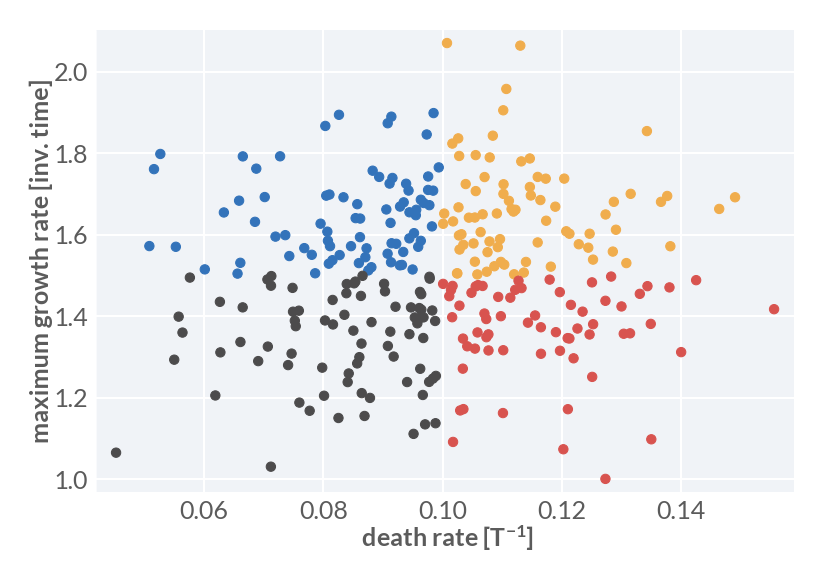

In [2]:
# Generate normally distributed growth and death rates
N_s = 300
rng = np.random.default_rng(seed=2039)
lambda_nut_max = np.abs(rng.normal(1.5, 0.2, N_s))
gamma = np.abs(rng.normal(0.1, 0.02, N_s))

# Set colors given quadrant
quad_colors = {(0, 1): cor['primary_blue'],
               (1, 1): cor['primary_gold'], 
               (0, 0): cor['primary_black'], 
               (1, 0): cor['primary_red']} 
# Set a color vector
colors = []
for i in range(N_s):
    idx = [0, 0]
    if gamma[i] >= 0.1:
        idx[0] = 1
    if lambda_nut_max[i] >= 1.5:
        idx[1] = 1
    colors.append(quad_colors[tuple(idx)])

# Plot the distributions
fig, ax = plt.subplots(1,1, figsize=(3,2))
_ = ax.scatter(gamma, lambda_nut_max, c=colors, s=5)
_ = ax.set_ylabel(r'maximum growth rate [inv. time]', fontsize=6)
_ = ax.set_xlabel(r' death rate [T$^{-1}$]', fontsize=6)




Here, we've colored each species by its quadrant. Points that are blue demonstrate large growth rates, but death rates below the population average. Red is the inverse, where growth rates are below the population average, but the death rate is high. Of interest are the gold species, which demonstrate both high growth rates and high death rates. 

Using these parameters, we will now instantiate the species as `Species` objects.

In [3]:
# Define the parameters that are common to all species.
common_pars = {'Km_nut': 0.1, # Monod constant for nutrient growth
               'Y_nut': 0.3, # Yield coefficient
               # Necromass consumption parameters, set to 0 
               'lambda_necro_max': 0.05,
               'Km_necro': 0.1,
               'Y_necro': 0.1}

# Set a vector of speecies
species = [growth.model.Species(lambda_nut_max=lambda_nut_max[i], 
                                gamma=gamma[i], **common_pars) for i in range(N_s)]

# Integrating the ecosystem
With a vector of species, we can easily instantiate an ecosystem. As a first 
pass, we will initialize with a single bolus of nutrients, with no inflow 
or outflow.

In [4]:
# Set up the ecosystem
eco = growth.model.Ecosystem(species)
species_df, bulk_df = eco.grow(30, feed_conc=100, feed_freq=0.1, delta=0)


Growing ecosystem...: 100%|██████████| 3/3 [00:28<00:00,  9.33s/it]

done!


Text(0, 0.5, 'species frequency')

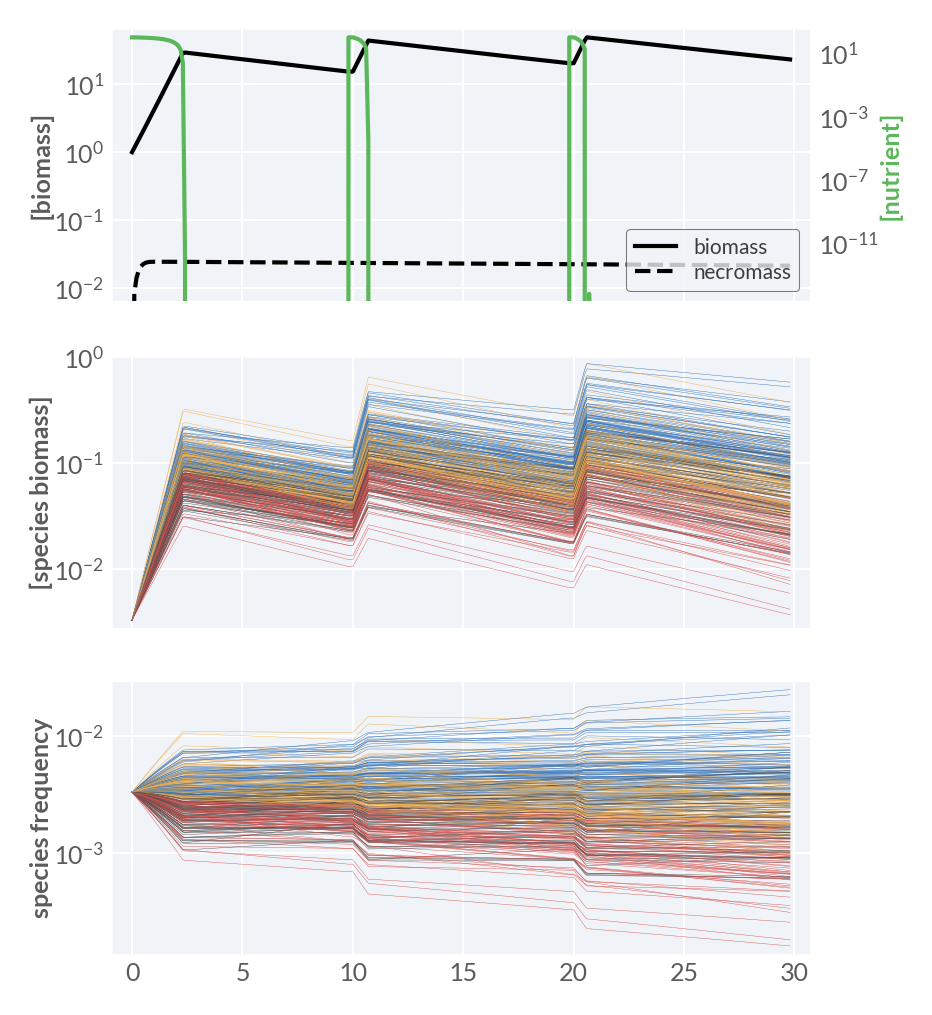

In [5]:
# Map colors to each species
color_mapper = {i+1: colors[i] for i in range(N_s)}
species_df['color'] = species_df['species_idx'].map(color_mapper)

# Plot the individual species and the bulk information
fig, ax = plt.subplots(3, 1, figsize=(3, 4),sharex=True)
twinx = ax[0].twinx()

# PLot the bulk information
ax[0].plot(bulk_df['time'], bulk_df['M_bio_tot'], 'k-', lw=1, label='biomass')
ax[0].plot(bulk_df['time'], bulk_df['M_necro_tot'], 'k--', lw=1, label='necromass')
twinx.plot(bulk_df['time'], bulk_df['M_nut'], '-', color=cor['primary_green'],
           lw=1)

# Plot dynamics of individual species
for g, d in species_df.groupby('species_idx'):
    ax[1].plot(d['time'], d['M_bio'], '-', color=d['color'].values[0], lw=0.1)
    ax[2].plot(d['time'], d['mass_frequency'], color=d['color'].values[0], lw=0.1)

# Format each axis
for a in ax:
    a.set_yscale('log')
# ax[0].set_ylim(1, 1E2)
ax[0].legend(fontsize=5, loc='lower right')
twinx.set_yscale('log')
twinx.grid(False)

# Add labels
ax[0].set_ylabel('[biomass]', fontsize=6)
twinx.set_ylabel('[nutrient]', fontsize=6, color=cor['primary_green'])
ax[1].set_ylabel('[species biomass]', fontsize=6)
ax[2].set_ylabel('species frequency', fontsize=6)





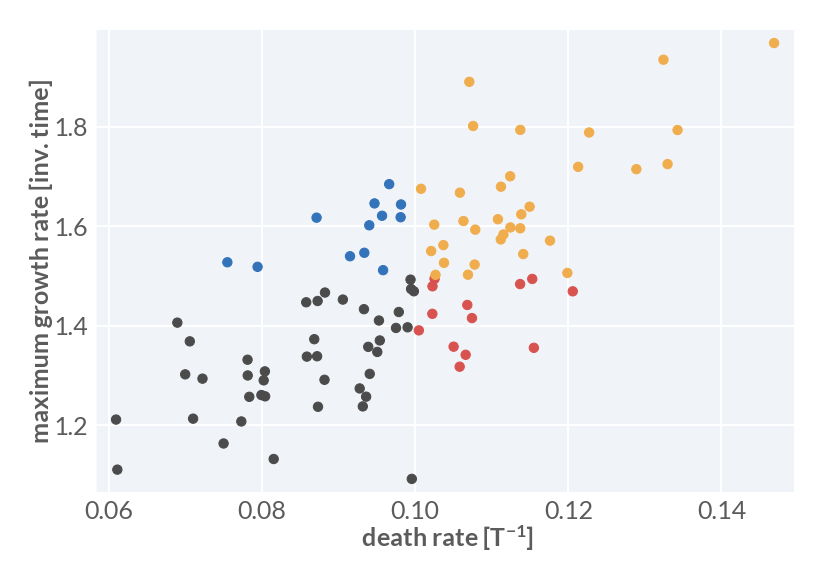

In [6]:
# Generate normally distributed growth and death rates
N_s = 100
rng = np.random.default_rng(seed=2039)
means = [1.5, 0.1]
sig = [0.2, 0.02]
corr = 0.75
cov = [[sig[0]**2, corr * sig[0] * sig[1]],[corr * sig[0] * sig[1], sig[1]**2]]
out = rng.multivariate_normal(means, cov, N_s)
lambda_nut_max = out[:, 0]
gamma = out[:, 1]

# Set colors given quadrant
quad_colors = {(0, 1): cor['primary_blue'],
               (1, 1): cor['primary_gold'], 
               (0, 0): cor['primary_black'], 
               (1, 0): cor['primary_red']} 
# Set a color vector
colors = []
for i in range(N_s):
    idx = [0, 0]
    if gamma[i] >= 0.1:
        idx[0] = 1
    if lambda_nut_max[i] >= 1.5:
        idx[1] = 1
    colors.append(quad_colors[tuple(idx)])

# Plot the distributions
fig, ax = plt.subplots(1,1, figsize=(3,2))
_ = ax.scatter(gamma, lambda_nut_max, c=colors, s=5)
_ = ax.set_ylabel(r'maximum growth rate [inv. time]', fontsize=6)
_ = ax.set_xlabel(r' death rate [T$^{-1}$]', fontsize=6)

In [7]:
# Define the parameters that are common to all species.
common_pars = {'Km_nut': 0.1, # Monod constant for nutrient growth
               'Y_nut': 0.3, # Yield coefficient
               # Necromass consumption parameters, set to 0 
               'lambda_necro_max': 0,
               'Km_necro': 0.1,
               'Y_necro': 0.1}

# Set a vector of speecies
species = [growth.model.Species(lambda_nut_max=lambda_nut_max[i], 
                                gamma=gamma[i], **common_pars) for i in range(N_s)]

In [8]:
# Set up the ecosystem
eco = growth.model.Ecosystem(species)
species_df, bulk_df = eco.grow(50, feed_conc=100, feed_freq=0.05, delta=0)


Growing ecosystem...: 100%|██████████| 3/3 [00:01<00:00,  2.25it/s]

done!


Text(0, 0.5, 'species frequency')

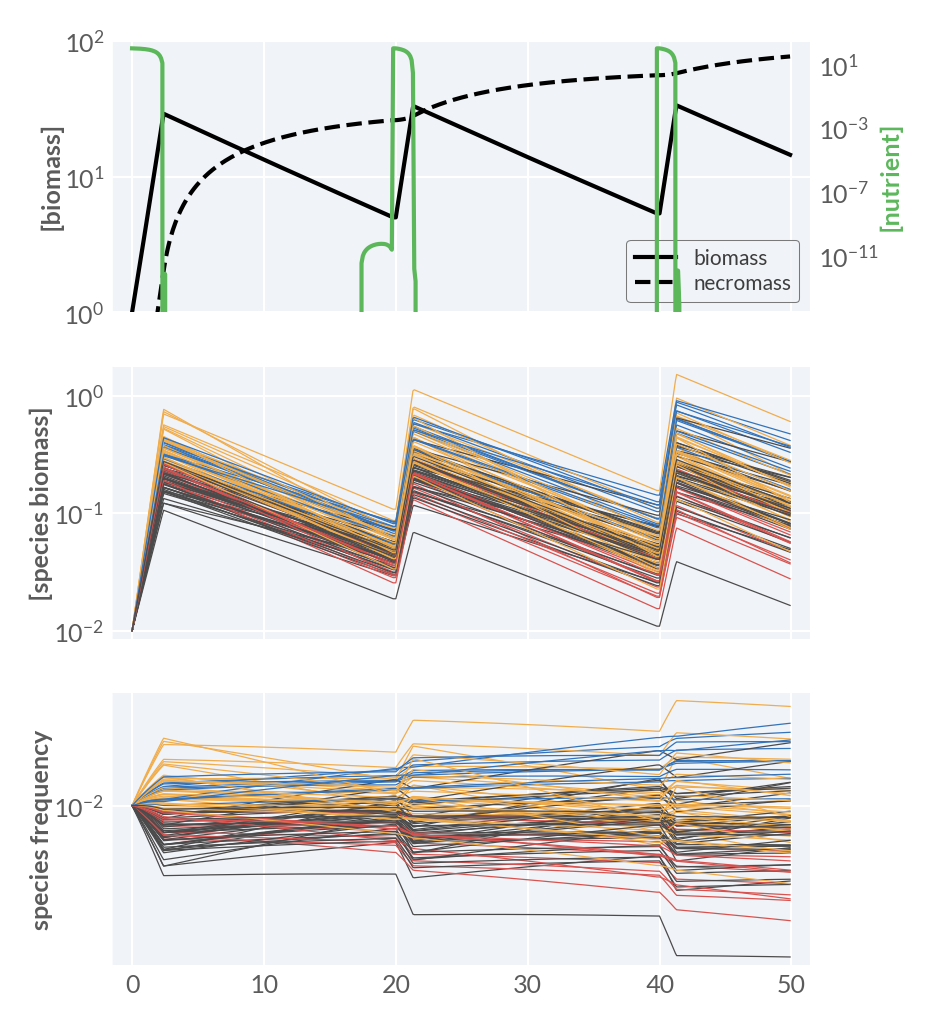

In [9]:
# Map colors to each species
color_mapper = {i+1: colors[i] for i in range(N_s)}
species_df['color'] = species_df['species_idx'].map(color_mapper)

# Plot the individual species and the bulk information
fig, ax = plt.subplots(3, 1, figsize=(3, 4),sharex=True)
twinx = ax[0].twinx()

# PLot the bulk information
ax[0].plot(bulk_df['time'], bulk_df['M_bio_tot'], 'k-', lw=1, label='biomass')
ax[0].plot(bulk_df['time'], bulk_df['M_necro_tot'], 'k--', lw=1, label='necromass')
twinx.plot(bulk_df['time'], bulk_df['M_nut'], '-', color=cor['primary_green'],
           lw=1)

# Plot dynamics of individual species
for g, d in species_df.groupby('species_idx'):
    ax[1].plot(d['time'], d['M_bio'], '-', color=d['color'].values[0], lw=0.3)
    ax[2].plot(d['time'], d['mass_frequency'], color=d['color'].values[0], lw=0.3)

# Format each axis
for a in ax:
    a.set_yscale('log')
ax[0].set_ylim(1, 1E2)
ax[0].legend(fontsize=5, loc='lower right')
twinx.set_yscale('log')
twinx.grid(False)

# Add labels
ax[0].set_ylabel('[biomass]', fontsize=6)
twinx.set_ylabel('[nutrient]', fontsize=6, color=cor['primary_green'])
ax[1].set_ylabel('[species biomass]', fontsize=6)
ax[2].set_ylabel('species frequency', fontsize=6)



